# Assignment 2

In this assignment, you need to implement the followings.


---


*   [1.1 Encoder](#encoder)
*   [1.2 Decoder](#decoder)
*   [1.3 Reparametrization Trick](#reparam)
*   [1.4 Loss Function](#loss)



# Import

In [1]:
# Imports
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import gridspec

#GPU setting

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Hyperparameter setting

In [11]:
batch_size = 100      
e_hidden = 500        # the number of hidden units in the encoder.
d_hidden = 500        # the number of hidden units in the decoder.
latent_dim = 10       
learning_rate = 0.001 
weight_decay = 1e-5   
epochs = 20          # the number of epochs

#Data Loading

In [6]:
# Set up Transformations (0-1 Scaling only)
t = transforms.Compose([transforms.ToTensor()])

trainset = torch.load('../data/dataset.pt')
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Variational Auto-Encoder

<a name="encoder"></a>
# 1.1 Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_features=100*100, e_hidden=200, latent_dim=10):
        """Encoder Class"""
        super(Encoder, self).__init__()
        # Encoder
        ##################################### 
        # Write your code here
        self.fc_input1 = nn.Linear(in_features, e_hidden)
        self.fc_input2 = nn.Linear(e_hidden, e_hidden)
        self.bn1 = nn.
        self.fc_mu = nn.Linear(e_hidden, latent_dim)
        self.fc_logvar = nn.Linear(e_hidden, latent_dim)
        
        self.training = True
        ##################################### 
    
    def forward(self, x):
        # Encode x to z
        ##################################### 
        # Write your code here
        h_ = F.relu(self.fc_input1(x))
        h_ = F.relu(self.fc_input2(h_))
        mu = self.fc_mu(h_)
        logvar = self.fc_logvar(h_)
        ##################################### 
        
        return mu, logvar

<a name="decoder"></a>
# 1.2 Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, in_features=100*100, d_hidden=200, latent_dim=10):
        """Decoder Class"""
        super(Decoder, self).__init__()

        # Decoder
        ##################################### 
        # Write your code here
        self.fc_hidden1 = nn.Linear(latent_dim, d_hidden)
        self.fc_hidden2 = nn.Linear(d_hidden, d_hidden)
        self.fc_x_recon = nn.Linear(d_hidden, in_features)
        ##################################### 
        

    def forward(self, z):        
        # Decode z to x'
        ##################################### 
        # Write your code here
        h = F.relu(self.fc_hidden1(z))
        h = F.relu(self.fc_hidden2(h))
        
        x_recon = F.sigmoid(self.fc_x_recon(h))
        ##################################### 
        
        return x_recon

<a name="reparam"></a>
# 1.3 Reparametrization Trick

In [9]:
class VAE(nn.Module):
    def __init__(self, in_features=100*100, e_hidden=200, d_hidden=200, latent_dim=10):
        """Variational Auto-Encoder Class"""
        super(VAE, self).__init__()
        
        self.encoder = Encoder(in_features, e_hidden, latent_dim)
        self.decoder = Decoder(in_features, d_hidden, latent_dim)
    
    # Reparameterization Trick
    def reparameterize(self, mu, logvar):
        ##################################### 
        # Write your code here
        var = torch.exp(0.5*logvar) # logvar -> var
        epsilon = torch.randn_like(var).to(device)
        z = mu + var*epsilon
        ##################################### 
        return z

    def forward(self, x):
        # Encode x to z
        mu, logvar = self.encoder(x)
        
        # Sample z from mu and logvar
        if self.training:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu
        
        # Decode z to x'
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar

<a name="loss"></a>
# 1.4 Loss for VAE

In [23]:
# Loss
def vae_loss(image, reconstruction, mu, logvar):
    
    """
    Loss for the Variational AutoEncoder.
    The loss can be composed of two terms, reconstruction loss and the KL divergence loss.
    Please not that we try to minimize the loss, not to maximize.
    """
    ##################################### 
    # Write your code here
    BCE = F.mse_loss(reconstruction, image, reduction='sum')
    #reproduction_loss = nn.functional.binary_cross_entropy(reconstruction, image, reduction='sum')
    KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    loss = BCE + KLD
    #####################################
    return loss

#Training

In [24]:
# Initialize VAE
vae = VAE(in_features=100*100, e_hidden=e_hidden, d_hidden=d_hidden, latent_dim=latent_dim)
vae = vae.to(device)
# Optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()

# Train
losses = []

for epoch in range(epochs):
    losses.append(0)
    number_of_batches = 0

    for frame_before, frame_after in trainloader:

        frame_before = frame_before.to(device)
        frame_after = frame_after.to(device)
        # Flatten images to [batch_size, input_features]
        frame_before = frame_before.view(-1, 100*100)
        frame_after = frame_after.view(-1, 100*100)

        optimizer.zero_grad()

        # Feed inputs to VAE
        reconstructions, latent_mu, latent_logvar = vae(frame_before)
        loss = vae_loss(frame_after, reconstructions, latent_mu, latent_logvar)/batch_size

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses[-1] += loss.item()  
        number_of_batches += 1

    # Print average loss
    losses[-1] /= number_of_batches
    print('Epoch [%d / %d] Loss: %f' % (epoch+1, epochs, losses[-1]))    

c:\Users\sbin_LAB\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

# Reconstruction Test

In [21]:
def reconstruction_images(images, labels):
    gs = gridspec.GridSpec(10,11,width_ratios=[1,1,1,1,1,0.3,1,1,1,1,1])
    plt.figure(figsize=[16,15])

    reconstructions, latent_mu, latent_logvar = vae(images)
    loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)/batch_size

    # Compare true images and reconstructed images
    for i in range(10):
        label = np.where(labels==i)[0][:5]
        for j,idx in enumerate(label):
            true_sample = images[idx].view(100, 100).cpu().detach().numpy()
            recon_sample = reconstructions[idx].view(100, 100).cpu().detach().numpy()

            if i <= 4:
                k = i*2
                l = j
            else:
                k = (i-5)*2
                l = j+6
            plt.subplot(gs[k,l]) 
            plt.imshow(true_sample, cmap='gray_r')
            plt.xticks([])
            plt.yticks([])
            if j ==0:
                plt.ylabel('Label: {}\nTrue'.format(i), fontsize=15)

            plt.subplot(gs[k+1,l])
            plt.imshow(recon_sample, cmap='gray_r')
            plt.xticks([])
            plt.yticks([])
            if j ==0:
                plt.ylabel('Recon'.format(i), fontsize=15)

    plt.savefig('reconstruction_results.png')
    plt.show()


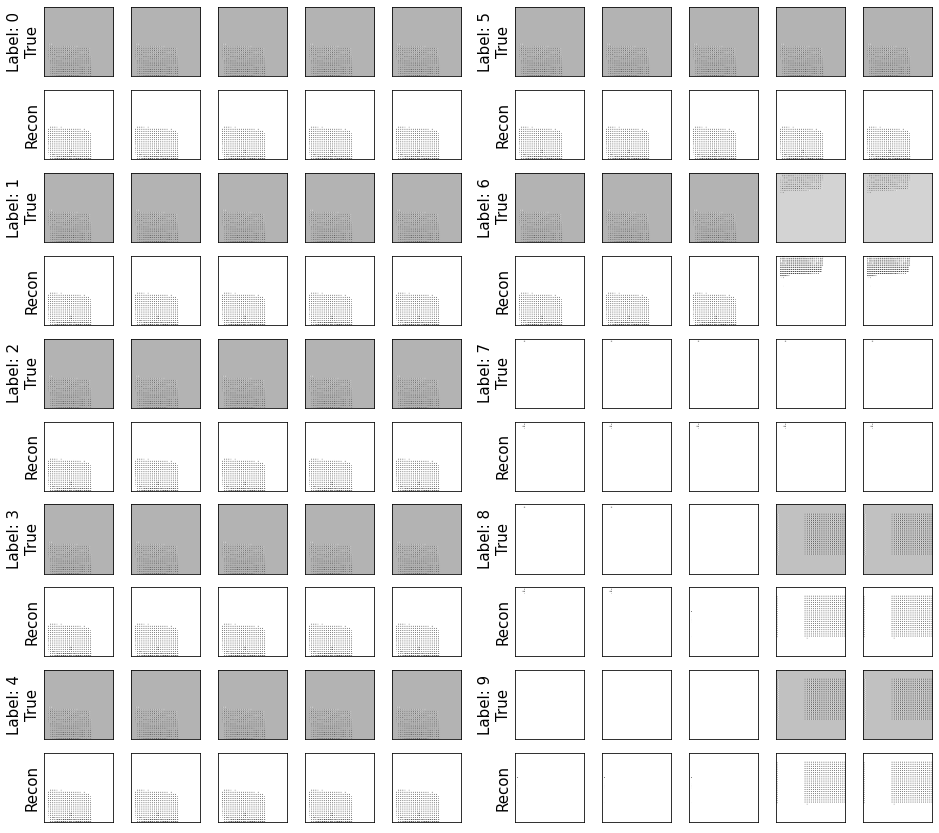

In [22]:
vae.eval()

for images, labels in trainloader:
    # if torch.sum(labels)!= 450: continue
    images = images.to(device).view(-1, 100*100)
    optimizer.zero_grad()
    reconstruction_images(images,labels)
    break

# Visualize Latent Space

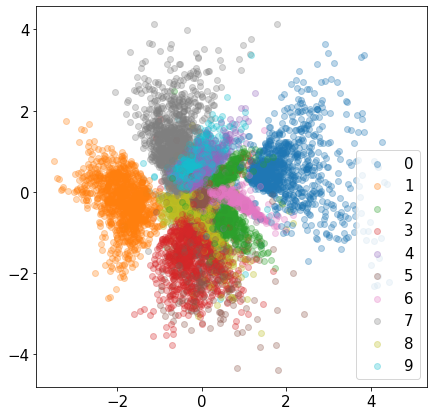

In [28]:
plt.figure(figsize=[7,7])
first = True

for images, labels in testloader:
    images = images.to(device).view(-1, 28*28)
    optimizer.zero_grad()
    _, latent_mu, latent_logvar = vae(images)

    latent_mu, latent_logvar = latent_mu.detach().cpu(), latent_logvar.detach().cpu()
    for i in range(10):
        idx = np.where(labels==i)[0]
        if first:
            plt.scatter(latent_mu[idx,0], latent_mu[idx,1], color='C{}'.format(i),alpha=0.3, label='{}'.format(i))
        else:
            plt.scatter(latent_mu[idx,0], latent_mu[idx,1], color='C{}'.format(i),alpha=0.3)
    first = False

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('latent_space.png')
plt.show()

# Additional Training for 1000 epochs

Epoch [1 / 300] Loss: 177.926935
Epoch [2 / 300] Loss: 155.543761
Epoch [3 / 300] Loss: 150.178830
Epoch [4 / 300] Loss: 147.471938
Epoch [5 / 300] Loss: 145.750345
Epoch [6 / 300] Loss: 144.507348
Epoch [7 / 300] Loss: 143.474423
Epoch [8 / 300] Loss: 142.727522
Epoch [9 / 300] Loss: 142.072306
Epoch [10 / 300] Loss: 141.329277
Epoch [11 / 300] Loss: 141.101291
Epoch [12 / 300] Loss: 140.684877
Epoch [13 / 300] Loss: 140.475640
Epoch [14 / 300] Loss: 140.181196
Epoch [15 / 300] Loss: 139.791283
Epoch [16 / 300] Loss: 139.582029
Epoch [17 / 300] Loss: 139.149549
Epoch [18 / 300] Loss: 138.785595
Epoch [19 / 300] Loss: 138.733986
Epoch [20 / 300] Loss: 138.523549
Epoch [21 / 300] Loss: 138.292266
Epoch [22 / 300] Loss: 138.243142
Epoch [23 / 300] Loss: 138.059964
Epoch [24 / 300] Loss: 137.945012
Epoch [25 / 300] Loss: 137.542758
Epoch [26 / 300] Loss: 137.393497
Epoch [27 / 300] Loss: 137.432425
Epoch [28 / 300] Loss: 137.222380
Epoch [29 / 300] Loss: 137.091760
Epoch [30 / 300] Loss: 

Epoch [239 / 300] Loss: 129.872811
Epoch [240 / 300] Loss: 130.163764
Epoch [241 / 300] Loss: 130.226777
Epoch [242 / 300] Loss: 130.357382
Epoch [243 / 300] Loss: 129.812596
Epoch [244 / 300] Loss: 129.765406
Epoch [245 / 300] Loss: 130.138895
Epoch [246 / 300] Loss: 129.942455
Epoch [247 / 300] Loss: 129.772802
Epoch [248 / 300] Loss: 129.494535
Epoch [249 / 300] Loss: 129.576408
Epoch [250 / 300] Loss: 129.724175
Epoch [251 / 300] Loss: 130.004509
Epoch [252 / 300] Loss: 130.086440
Epoch [253 / 300] Loss: 130.141493
Epoch [254 / 300] Loss: 130.096736
Epoch [255 / 300] Loss: 129.620690
Epoch [256 / 300] Loss: 129.318035
Epoch [257 / 300] Loss: 129.357902
Epoch [258 / 300] Loss: 129.487758
Epoch [259 / 300] Loss: 129.625567
Epoch [260 / 300] Loss: 129.501661
Epoch [261 / 300] Loss: 129.623966
Epoch [262 / 300] Loss: 129.712440
Epoch [263 / 300] Loss: 129.638066
Epoch [264 / 300] Loss: 129.612620
Epoch [265 / 300] Loss: 129.571624
Epoch [266 / 300] Loss: 129.330148
Epoch [267 / 300] Lo

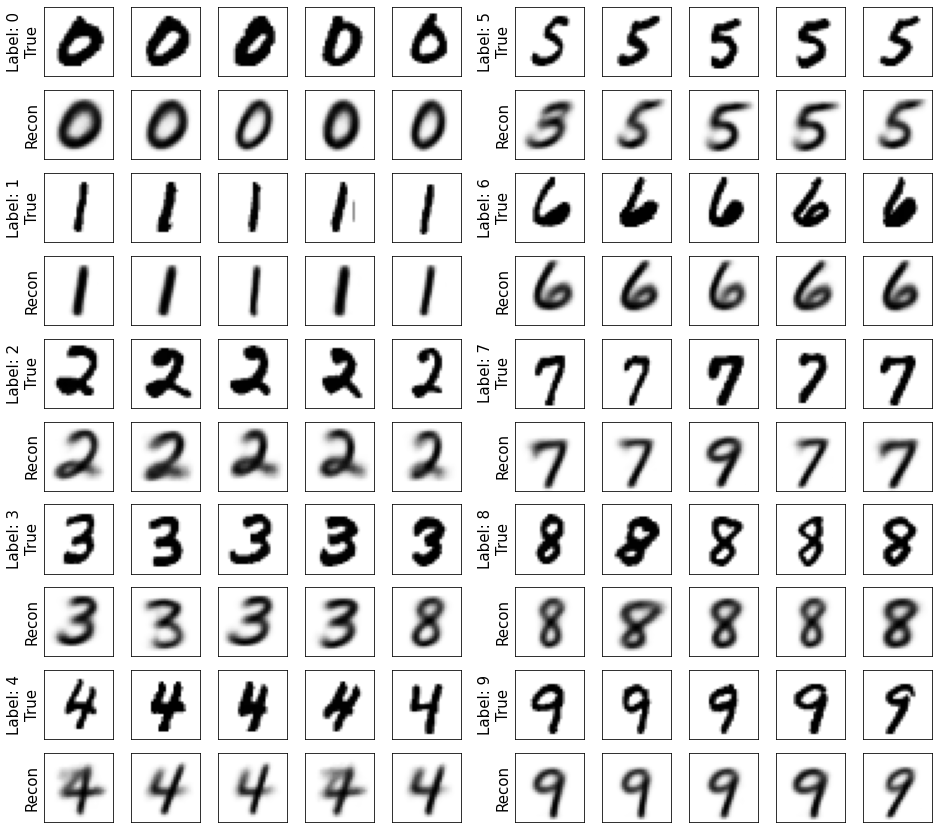

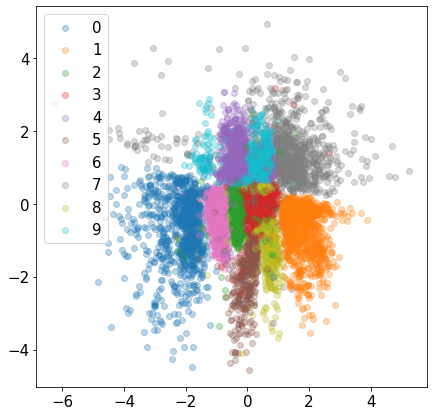

In [29]:
epochs_300 = 300
# Initialize VAE
vae = VAE(in_features=28*28, e_hidden=e_hidden, d_hidden=d_hidden, latent_dim=latent_dim)
vae = vae.to(device)
# Optimizer
optimizer = optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
vae.train()

# Train
losses = []

for epoch in range(epochs_300):
    losses.append(0)
    number_of_batches = 0

    for images, _ in trainloader:

        images = images.to(device)
        # Flatten images to [batch_size, input_features]
        images = images.view(-1, 28*28)

        optimizer.zero_grad()

        # Feed inputs to VAE
        reconstructions, latent_mu, latent_logvar = vae(images)
        loss = vae_loss(images, reconstructions, latent_mu, latent_logvar)/batch_size

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses[-1] += loss.item()  
        number_of_batches += 1

    # Print average loss
    losses[-1] /= number_of_batches
    print('Epoch [%d / %d] Loss: %f' % (epoch+1, epochs_300, losses[-1]))    
    
vae.eval()

for images, labels in testloader:
    if torch.sum(labels)!= 450: continue
    images = images.to(device).view(-1, 28*28)
    optimizer.zero_grad()
    reconstruction_images(images,labels)
    break
    
plt.figure(figsize=[7,7])
first = True

for images, labels in testloader:
    images = images.to(device).view(-1, 28*28)
    optimizer.zero_grad()
    _, latent_mu, latent_logvar = vae(images)

    latent_mu, latent_logvar = latent_mu.detach().cpu(), latent_logvar.detach().cpu()
    for i in range(10):
        idx = np.where(labels==i)[0]
        if first:
            plt.scatter(latent_mu[idx,0], latent_mu[idx,1], color='C{}'.format(i),alpha=0.3, label='{}'.format(i))
        else:
            plt.scatter(latent_mu[idx,0], latent_mu[idx,1], color='C{}'.format(i),alpha=0.3)
    first = False

plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.savefig('latent_space_300.png')
plt.show()

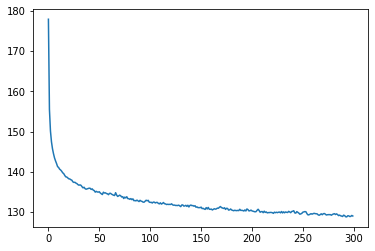

In [30]:
plt.plot(losses)
plt.show()

# Visualization for Report

In [23]:
# from torchviz import make_dot
# import graphviz

In [20]:
# for images, labels in testloader:
#     images = images.to(device).view(-1, 28*28)
# enc_viz = Encoder(28*28, e_hidden, latent_dim).to(device)
# y = enc_viz(images)
# make_dot(y, params=dict(enc_viz.named_parameters())).render("enc_st", format="png")

'enc_st.png'

In [21]:
# z = torch.Tensor(2).to(device)
# dec_viz = Decoder(28*28, d_hidden, latent_dim).to(device)
# y = dec_viz(z)
# make_dot(y, params=dict(enc_viz.named_parameters())).render("dec_st", format="png")

'dec_st.png'

In [22]:
# vae_viz = VAE(in_features=28*28, e_hidden=e_hidden, d_hidden=d_hidden, latent_dim=latent_dim).to(device)
# y = vae_viz(images)
# make_dot(y, params=dict(enc_viz.named_parameters())).render("vae_st", format="png")

'vae_st.png'